### Marchenko Pastur Distribution

We are going to study the eigenvalues of large covariance matrices using Marchenko-Pastur probability density function of random matices.

**Motivation**

time series 데이터의 correlation 상에서 signal을 발견한다면, 우리는 시간 $t$에서 $Y(t+h)$의 가격을 예측하기 위해 딥러닝 혹은 머신러닝 기술들을 활용하는 것을 고려할 수 있다.

Random Matrix Theory에 따르면, large rectangular random matrices라면 singular value의 개수는 marchenko-pastur 분포를 따라야 한다.

$$f(\lambda) = \frac{T}{N} \frac{\sqrt{(\lambda_+ - \lambda)(\lambda_- - \lambda)}}{2\pi \lambda \sigma^2} \mathbb{1}_{(\lambda_-, \lambda_+)}$$

where

$$\lambda_+ = \sigma^2 \left(1 + \sqrt{\frac{N}{T}}\right)^2\lambda_- = \sigma^2 \left(1 - \sqrt{\frac{N}{T}}\right)^2$$

In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pylab as plt
from scipy.optimize import minimize
from FinancialMachineLearning.machine_learning.clustering import marchenko_pastur_prob_distribution

N = 1000
T = 10000
pdf0 = marchenko_pastur_prob_distribution(1., q=T/N, pts=N)

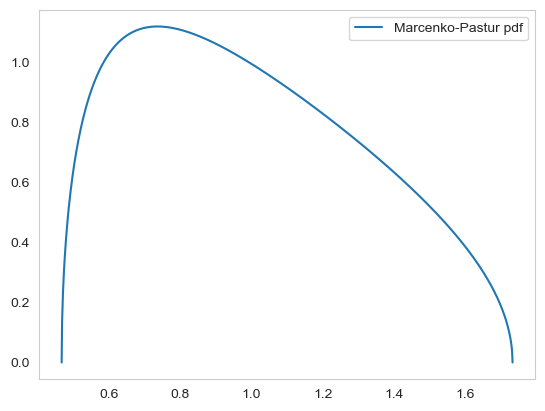

In [5]:
plt.plot(
    pdf0.keys(), 
    pdf0, 
    label = "Marcenko-Pastur pdf"
)
plt.legend()
plt.grid(False)
plt.show()

#### Correlation Matrices

$$\mathrm{Corr}(X,Y) = \frac{\mathrm{Cov}(X,Y)}{\sigma_x, \sigma_y}$$

$$\mathrm{Cov}(X,Y) = E[(X - E[X])(Y - E[Y])] = 
\sum_{i=0}^{i=n} \frac{(X_i - \mu_x)(Y_i - \mu_y)}{n-1}
$$

In [6]:
N = 1000 
T = 10000 
x = np.random.normal(0, 1, size = (T, N))
# x has 1000 indicators - one pr column - with rows=10.000 time-steps
cor = np.corrcoef(x, rowvar=0) 
print(cor.shape)

(1000, 1000)


In [7]:
from FinancialMachineLearning.machine_learning.clustering import getPCA

eVal0 , eVec0 = getPCA(cor) 
pdf0 = marchenko_pastur_prob_distribution(1., q=x.shape[0]/float(x.shape[1]), pts=N)

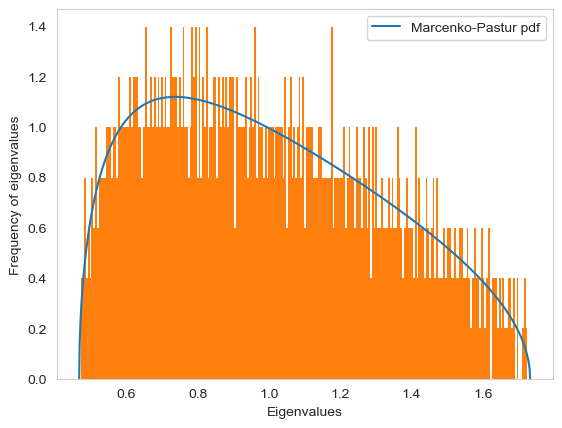

In [13]:
plt.plot(pdf0.keys(), pdf0, label = "Marcenko-Pastur pdf")
plt.hist(np.diag(eVal0), density = True, bins = 250, edgecolor = 'none') # Histogram the eigenvalues

plt.legend()
plt.grid(False)
plt.ylabel("Frequency of eigenvalues")
plt.xlabel("Eigenvalues")
plt.show()

#### Random Walk

Lets define a random walk as a stocastic discrete-time process with a continous state-space. It is not a stationary process.

Does two or more random walks have correlation?

In [14]:
def random_walk(N, seed):
    """
    Simulates a continuous random walk
    :param int N : the number of steps to take
    """
    np.random.seed(seed)
    
    # the epsilon values
    random_increments = np.random.normal(0, 1, size=N) #mu=0, var=1
    # calculate the random walk
    random_walk = np.cumsum(random_increments)
    
    # return the entire walk and the increments
    return random_walk, random_increments

In [15]:
N = 500
X, epsilon = random_walk(N, 42)

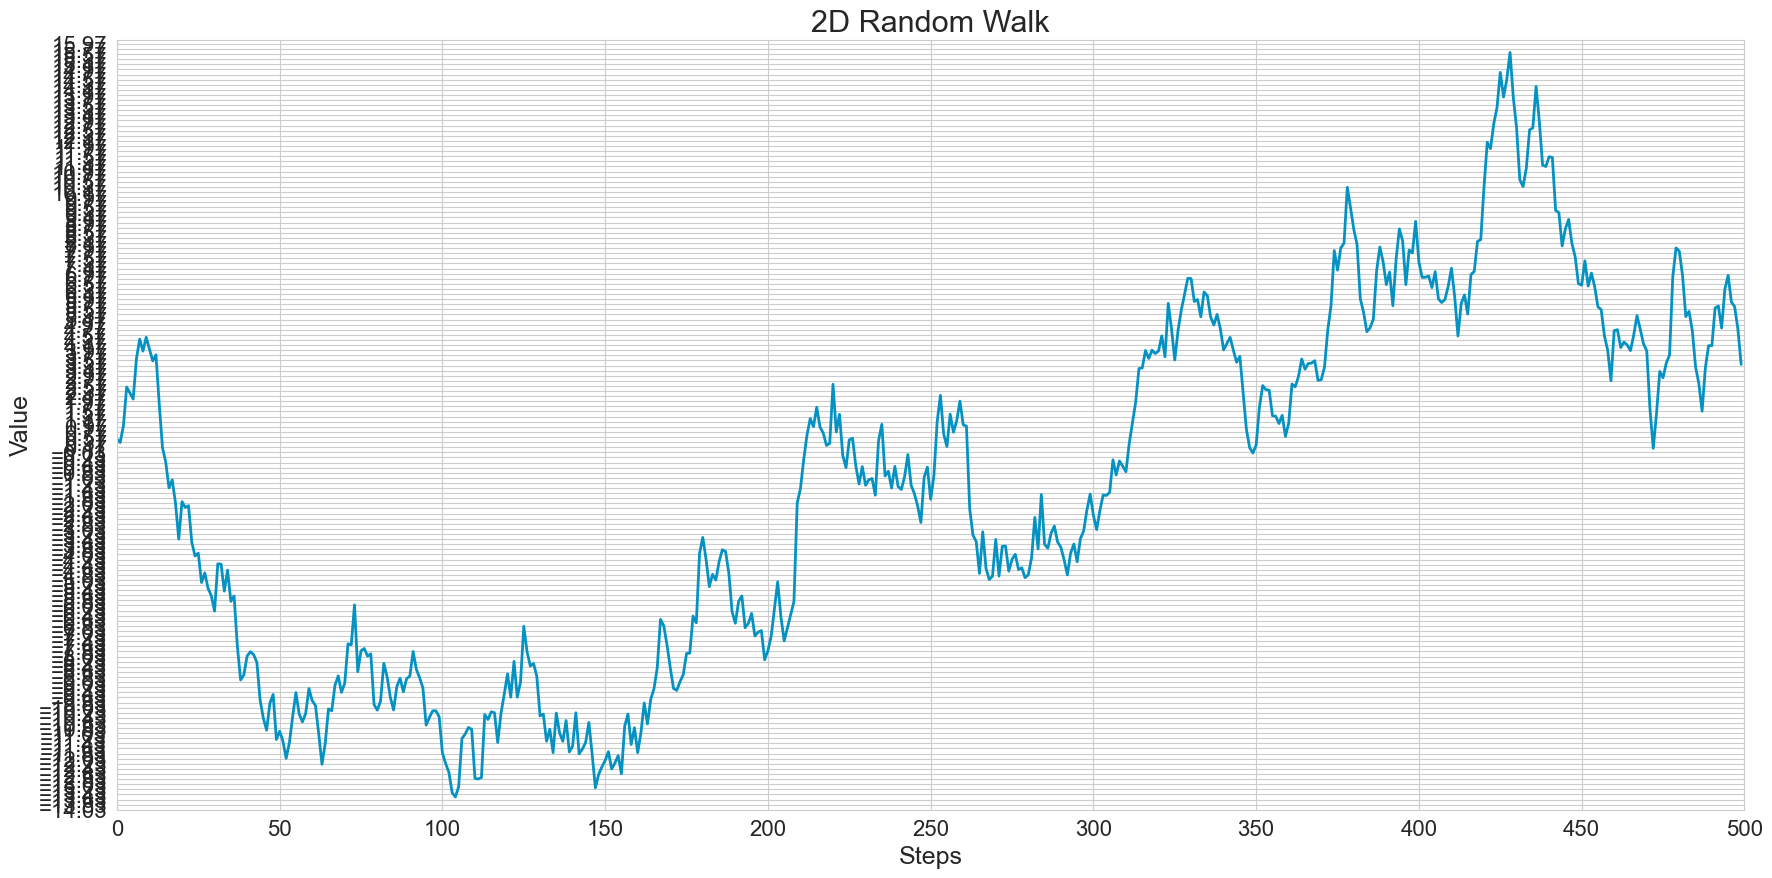

In [18]:
import networkx as nx
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter

fig = plt.figure(figsize=(21, 10))
ax = plt.axes(xlim=(0, N), ylim=(np.min(X) - 0.5, np.max(X) + 0.5)) 
line, = ax.plot([], [], lw=2, color='#0492C2')
ax.set_xticks(np.arange(0, N+1, 50))
ax.set_yticks(np.arange(np.min(X) - 0.5, np.max(X) + 0.5, 0.2))
ax.set_title('2D Random Walk', fontsize=22)
ax.set_xlabel('Steps', fontsize=18)
ax.set_ylabel('Value', fontsize=18)
ax.tick_params(labelsize=16)

# initialization function 
def init(): 
    # creating an empty plot/frame 
    line.set_data([], []) 
    return line, 

# lists to store x and y axis points 
xdata, ydata = [], []

# animation function 
def animate(i):
    y = X[i] #animate random walk
    # appending new points to x, y axes points list 
    xdata.append(i) 
    ydata.append(y) 
    line.set_data(xdata, ydata) 
    return line,

# call the animator	 
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=N, interval=20, blit=True)
anim.save('random_walk.gif',writer=PillowWriter(fps=20)) #writer='imagemagick') 

In [19]:
N = 1000
T = 10000
time_series = np.zeros(shape=(T,N))
change_series = np.zeros(shape=(T,N))
X_norm = [0] * N
dt = 1./N # the time step

changeCount = 0
for i in range(0,N):
    time_series[:,i], _ = random_walk(T, i)
    X_norm[i] = time_series[T - 1, i] * np.sqrt(dt)

for i in range(0,N):
    changeCount = 0
    for j in range(0,T):
        if j>0:
            change_series[j-1, i] = time_series[j, i] - time_series[j-1, i]

In [20]:
cor = np.corrcoef(time_series, rowvar = 0) 
eVal0, eVec0 = getPCA(cor) 

In [21]:
cor1 = np.corrcoef(change_series, rowvar = 0) 
eVal_change, _ = getPCA(cor1) 
eVal_change = np.diag(eVal_change)

In [22]:
eVal0 = np.diag(eVal0)
print('30 largest eigenvalues from random walk correlation matrix')
print(np.sort(eVal0)[-30:])
q_ = time_series.shape[0]/float(time_series.shape[1])
var=1.
eMin, eMax = var*(1-(1./q_)**.5)**2, var*(1+(1./q_)**.5)**2
print('lambda_pluss from mp pdf')
print(eMax)

eVal1 = np.copy(eVal0)
for i in range(0, len(eVal0)):
    if eVal0[i] > eMax:
        eVal1[i] = 2*eMax

30 largest eigenvalues from random walk correlation matrix
[  1.19715754   1.2755253    1.4027892    1.61557919   1.67802462
   1.75117811   1.8713399    2.09901171   2.30298901   2.32025626
   2.51292945   2.77347453   3.42469322   3.51159903   4.26334568
   4.65204882   5.56338354   6.55664369   7.53721128  10.09466695
  10.61595442  13.49520315  16.62376778  22.62683985  27.63782549
  42.92342463  58.54323963 101.97656794 159.62263396 442.96900928]
lambda_pluss from mp pdf
1.732455532033676


In [23]:
pdf0 = marchenko_pastur_prob_distribution(1., q = q_, pts = N)

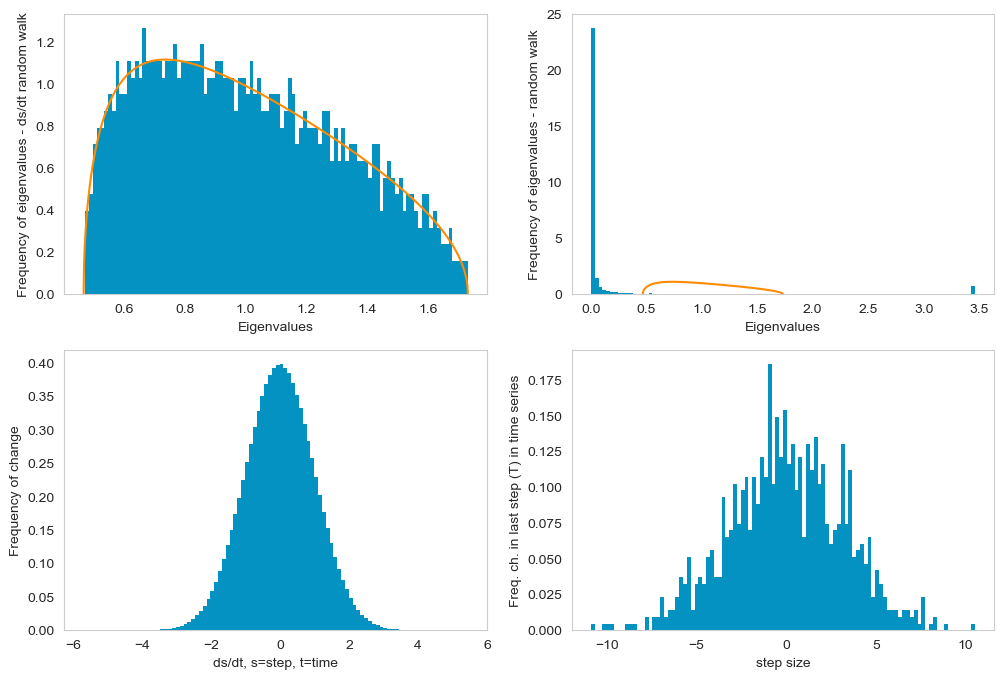

In [28]:
fig = plt.figure(figsize=(12,8), dpi=100)
ax  = fig.add_subplot(221)
ax1 = plt.subplot(222)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)
ax.hist(eVal_change, density=True, bins=100, edgecolor = 'none', color='#0492C2')
ax.plot(pdf0.keys(), pdf0, label="Marcenko-Pastur pdf", color = 'darkorange')
ax.grid(False)
ax1.hist(eVal1, density = True, bins = 100, edgecolor = 'none', color='#0492C2') # Histogram the eigenvalues
ax1.plot(pdf0.keys(), pdf0, label = "Marcenko-Pastur pdf", color = 'darkorange')
ax1.grid(False)
ax2.hist(change_series.flatten(), bins = 100, density = True, color = '#0492C2', edgecolor = 'none')
ax2.grid(False)
ax3.hist(X_norm, bins = 100, density=True, color='#0492C2', edgecolor = 'none')
ax3.grid(False)

ax.set_ylabel("Frequency of eigenvalues - ds/dt random walk")
ax.set_xlabel("Eigenvalues")
ax1.set_ylabel("Frequency of eigenvalues - random walk")
ax1.set_xlabel("Eigenvalues")
ax2.set_ylabel("Frequency of change")
ax2.set_xlabel("ds/dt, s=step, t=time")
ax3.set_ylabel("Freq. ch. in last step (T) in time series")
ax3.set_xlabel("step size")
plt.show()